In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torchvision
import sklearn
import matplotlib
import numpy as np

print("PyTorch version:", torch.__version__)
print("TorchVision version:", torchvision.__version__)
print("scikit-learn version:", sklearn.__version__)
print("Matplotlib version:", matplotlib.__version__)
print("NumPy version:", np.__version__)


PyTorch version: 2.4.0+cu118
TorchVision version: 0.19.0+cu118
scikit-learn version: 1.5.1
Matplotlib version: 3.9.2
NumPy version: 1.26.3


Verificamos si tenemos CUDA disponible, este cuadernillo se corrió de manera local, por tanto, nos detecta nuestra tarjeta gráfica NVIDIA GeForce GTX 1060 de 6GB de memoria

In [ ]:
import torch

# Verificar si CUDA está disponible
cuda_available = torch.cuda.is_available()

# Imprimir si CUDA está disponible y la versión de CUDA
print(f"CUDA disponible: {cuda_available}")

if cuda_available:
    print(f"Versión de CUDA: {torch.version.cuda}")
    print(f"Dispositivo CUDA: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA no está disponible.")


CUDA disponible: True
Versión de CUDA: 11.8
Dispositivo CUDA: NVIDIA GeForce GTX 1060 6GB


#Importar  Dataset

Las imagenes se las tiene en formato .jpg, no están en un archivo .csv ya que se generaba un archivo extremadamente grande (20gbs) con todas las imagenes.
Sin embargo, utilizando el enfoque de utilizar tensores directamente al cargar las imágenes, el proceso fue mas rápido y liviano.
Simplemente hay que cargar las imagenes en una carpeta que contenga subcarpetas, donde cada subcarpeta representa una categoría.

In [ ]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Ruta a la carpeta en Google Drive donde están las imágenes
image_dir = 'hojas2000'

# Definir las transformaciones para las imágenes
transform = transforms.Compose([
    transforms.Resize((192, 256)),  # Redimensionar a 256x192
    transforms.ToTensor(),  # Convertir a tensor
    transforms.Lambda(lambda x: x.view(-1))  # Aplanar imagen (opcional, verifica si lo necesitas)
])

# Cargar las imágenes y organizarlas en clases automáticamente según las carpetas
dataset = datasets.ImageFolder(root=image_dir, transform=transform)

# Dividir el dataset en entrenamiento y prueba
total_size = len(dataset)
train_size = int(0.8 * total_size)  # 80% para entrenamiento
test_size = total_size - train_size  # 20% para prueba
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Crear DataLoader para entrenamiento y prueba con batch_size de 256
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

# Imprimir dimensiones
print(f"Total de imágenes en el dataset: {total_size}")
print(f"Tamaño del conjunto de entrenamiento: {train_size}")
print(f"Tamaño del conjunto de prueba: {test_size}")

# Verificar las dimensiones del primer batch en los DataLoaders
for images, labels in train_loader:
    print(f"Dimensiones del primer batch de imágenes: {images.size()}")
    print(f"Dimensiones del primer batch de etiquetas: {labels.size()}")

    # Imprimir el valor mínimo y máximo de los tensores de imagen
    print(f"Valor mínimo de los tensores de imagen en el primer batch: {images.min().item()}")
    print(f"Valor máximo de los tensores de imagen en el primer batch: {images.max().item()}")

    break  # Solo necesitamos verificar el primer batch

for images, labels in test_loader:
    print(f"Dimensiones del primer batch de imágenes en prueba: {images.size()}")
    print(f"Dimensiones del primer batch de etiquetas en prueba: {labels.size()}")

    # Imprimir el valor mínimo y máximo de los tensores de imagen
    print(f"Valor mínimo de los tensores de imagen en el primer batch de prueba: {images.min().item()}")
    print(f"Valor máximo de los tensores de imagen en el primer batch de prueba: {images.max().item()}")
    break  # Solo necesitamos verificar el primer batch


Total de imágenes en el dataset: 10000
Tamaño del conjunto de entrenamiento: 8000
Tamaño del conjunto de prueba: 2000
Dimensiones del primer batch de imágenes: torch.Size([256, 147456])
Dimensiones del primer batch de etiquetas: torch.Size([256])
Valor mínimo de los tensores de imagen en el primer batch: 0.0
Valor máximo de los tensores de imagen en el primer batch: 1.0
Dimensiones del primer batch de imágenes en prueba: torch.Size([256, 147456])
Dimensiones del primer batch de etiquetas en prueba: torch.Size([256])
Valor mínimo de los tensores de imagen en el primer batch de prueba: 0.0
Valor máximo de los tensores de imagen en el primer batch de prueba: 1.0


Ademas de importar las imagenes en tensores, también se aplana a una sola dimension, para que podamos usarlo con el MLP

Ojo, como al importar las imagenes ya las tenemos convertidas en tensores y de paso normalizadas en valores entre 0 y 1, no se utiliza numpy para convertir a tensores, ya que todo se manejara con los datos importados como tensores.
Ademas, se reescalo las imagenes a 256x192, siendo una dimensión que aún permite visualizar correctamente las imagenes y reduce las características de entrada para alivianar el procesamiento del modelo y calculos de gradientes.

#Visualizar las imagenes

Siguiendo las buenas prácticas debemos ver si podemos visualizar una imagen, sin embargo, en la creación del dataset ya está aplanado en un vector todas las caracteristicas(pixeles) por tanto, para poder graficar las imagenes que estan en formato RGB, debemos "desaplanarlas" primero para poder graficarlas.

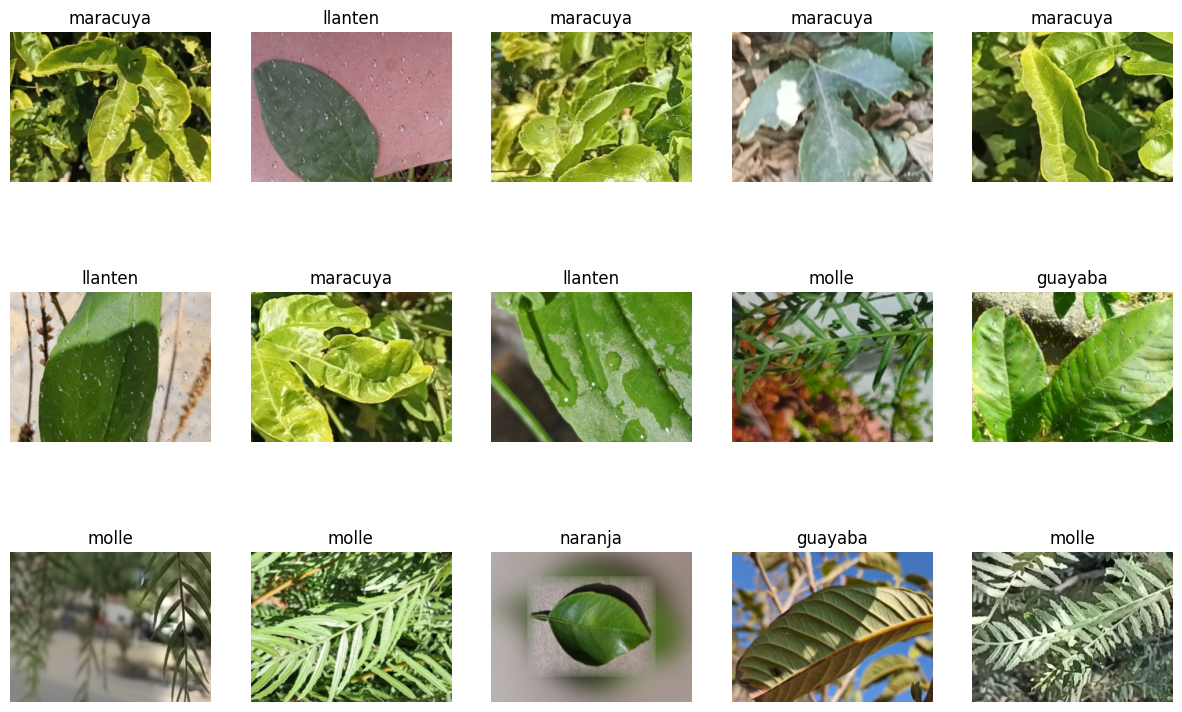

In [ ]:
import random
import matplotlib.pyplot as plt
# Función para desaplanar y visualizar imágenes con nombre de la clase
def unflatten_and_show(images, labels, classes, original_size=(192, 256)):
    # Convertir el tensor de imágenes a su forma original
    num_images = images.size(0)
    images_unflattened = images.view(num_images, 3, original_size[0], original_size[1])

    # Visualizar las imágenes
    r, c = 3, 5  # 3 filas, 5 columnas
    plt.figure(figsize=(c*3, r*3))

    for row in range(r):
        for col in range(c):
            index = c * row + col
            if index < num_images:
                plt.subplot(r, c, index + 1)
                img = images_unflattened[index]
                label = labels[index]
                plt.imshow(img.permute(1, 2, 0))  # Cambiar la forma para la visualización (canales a la última dimensión)
                plt.axis('off')
                plt.title(classes[label])  # Mostrar el nombre de la clase en lugar del índice

    plt.subplots_adjust(wspace=0.2, hspace=0.5)
    plt.show()

# Obtener un batch de imágenes y etiquetas
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Mostrar un batch de imágenes desaplanadas con nombre de la clase
unflatten_and_show(images, labels, dataset.classes)

#Comprobacion de tipos de datos

Siguiendo las buenas prácticas debemos verificar el tipo de datos con el que estamos trabajando, en este caso es correcto y además se nos fue proporcionado este tipo de dato por pytorch al crar los tensores.

In [ ]:
# Obtener un batch de imágenes y etiquetas
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Verificar el tipo de dato de los tensores
print(f"Tipo de dato de train_images: {images.dtype}")
print(f"Tipo de dato de train_labels: {labels.dtype}")


Tipo de dato de train_images: torch.float32
Tipo de dato de train_labels: torch.int64


#Distrubicion de Datos

Seguidamente toca graficar la distribucion de los datos de todas las clases con las que vamos a trabajar.

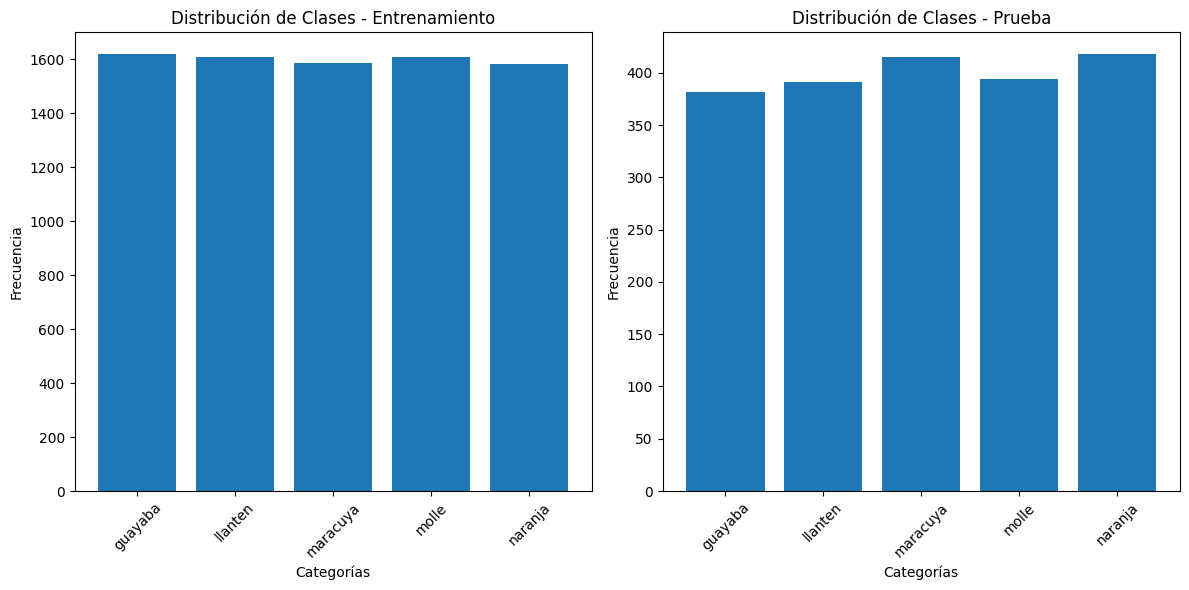

Categoría: guayaba, Conteo en Entrenamiento: 1618
Categoría: llanten, Conteo en Entrenamiento: 1609
Categoría: maracuya, Conteo en Entrenamiento: 1585
Categoría: molle, Conteo en Entrenamiento: 1606
Categoría: naranja, Conteo en Entrenamiento: 1582
Categoría: guayaba, Conteo en Prueba: 382
Categoría: llanten, Conteo en Prueba: 391
Categoría: maracuya, Conteo en Prueba: 415
Categoría: molle, Conteo en Prueba: 394
Categoría: naranja, Conteo en Prueba: 418


In [ ]:
# Inicializar contadores para la distribución de clases
train_class_counts = torch.zeros(len(dataset.classes), dtype=torch.int64)
test_class_counts = torch.zeros(len(dataset.classes), dtype=torch.int64)

# Contar las clases en el conjunto de entrenamiento
for _, labels in train_loader:
    for label in labels:
        train_class_counts[label] += 1

# Contar las clases en el conjunto de prueba
for _, labels in test_loader:
    for label in labels:
        test_class_counts[label] += 1

# Convertir los contadores a NumPy solo para la visualización
train_class_counts_np = train_class_counts.numpy()
test_class_counts_np = test_class_counts.numpy()

# Visualizar la distribución de clases para el conjunto de entrenamiento
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.bar(range(len(dataset.classes)), train_class_counts_np, tick_label=dataset.classes)
plt.xlabel('Categorías')
plt.ylabel('Frecuencia')
plt.title('Distribución de Clases - Entrenamiento')
plt.xticks(rotation=45)

# Visualizar la distribución de clases para el conjunto de prueba
plt.subplot(1, 2, 2)
plt.bar(range(len(dataset.classes)), test_class_counts_np, tick_label=dataset.classes)
plt.xlabel('Categorías')
plt.ylabel('Frecuencia')
plt.title('Distribución de Clases - Prueba')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Mostrar valores únicos y conteos para entrenamiento y prueba
for category, count in enumerate(train_class_counts_np):
    print(f"Categoría: {dataset.classes[category]}, Conteo en Entrenamiento: {count}")

for category, count in enumerate(test_class_counts_np):
    print(f"Categoría: {dataset.classes[category]}, Conteo en Prueba: {count}")


#Modelo MLP

Definimos un modelo secuencial con una capa oculta de 50 perceptrones(neuronas). La capa de entrada es 3*192*256, esto es debido a que al importar también escalamos las imágenes, y además como tenemos 3 canales (RGB) se debe multiplicar por 3.

In [ ]:
import torch
import torch.nn as nn

def build_model(D_in=3*192*256, H=50, D_out=5):
    """
    Crea un modelo de Perceptrón Multicapa (MLP) con una sola capa oculta.

    Args:
    - D_in (int): Número de características de entrada (tamaño de la imagen aplanada).
    - H (int): Número de unidades en la capa oculta (debe ser al menos 50).
    - D_out (int): Número de clases de salida.

    Returns:
    - model (nn.Module): Modelo MLP.
    """
    model = nn.Sequential(
        nn.Linear(D_in, H),
        nn.ReLU(),
        nn.Linear(H, D_out)
    )

    # Verificar si CUDA está disponible y mover el modelo a la GPU si es posible
    if torch.cuda.is_available():
        model = model.cuda()

    return model


##Prueba con datos aleatorios

Siguiendo los pasos de las buenas prácticas, tenemos que probar el modelo con datos aleatorios, para ver si la respuesta que obtenemos concuerda con lo esperado. Se confirma que es correcto debido a que el batchsize de la entrada es de 16 y tenemos 5 clases para la clasificación, si hubieramos obtenido otro resultado, tenemos que subsanar los problemas ahora, para no perder tiempo en los pasos posteriores que consumen más tiempo.

In [ ]:

# Crear el modelo
model = build_model()

# Crear una entrada aleatoria con el tamaño adecuado
test_input = torch.randn((16, 3*192*256))  # Tamaño del batch: 16, Tamaño de la imagen: 3*192*256

# Mover la entrada a GPU si está disponible
if torch.cuda.is_available():
    test_input = test_input.cuda()

# Pasar la entrada a través del modelo
test_output = model(test_input)

# Mostrar el tamaño de la salida
print(test_output.shape)

torch.Size([16, 5])


#Fit de un solo ejemplo

Toca proseguir con la prueba de un solo ejemplo, para ver el comportamiento con el objetivo de ver si el modelo puede memorizar(sobreajustarse) cuando hay solo un ejemplo, si no lograra esto entonces habría un problema con el modelo.

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

# Actualizar la función build_model para el nuevo tamaño de entrada
def build_model(D_in=192*256*3, H=50, D_out=5):
    return torch.nn.Sequential(
        torch.nn.Linear(D_in, H),
        torch.nn.ReLU(),
        torch.nn.Linear(H, D_out)
    ).to(device)  # Mover a la GPU si disponible

# Definir el dispositivo (GPU si disponible, sino CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Adaptar el Dataset para usar un solo ejemplo
class CustomDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

# Extraer un solo ejemplo del dataset de entrenamiento
example_image, example_label = train_dataset[0]  # Obtener el primer ejemplo del dataset

# Convertir el ejemplo a tensores y crear un DataLoader
example_image = example_image.view(1, -1)  # Aplana la imagen a un vector
example_label = torch.tensor([example_label])

dataset = CustomDataset(example_image, example_label)
dataloader = DataLoader(dataset, batch_size=1)

# Definir el modelo, criterio y optimizador
epochs = 5
criterion = torch.nn.CrossEntropyLoss()
model = build_model().to(device)  # Mover el modelo al dispositivo
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Entrenamiento del modelo
for e in range(1, epochs + 1):
    for x_b, y_b in dataloader:
        x_b, y_b = x_b.to(device), y_b.to(device)  # Mover los datos al dispositivo
        y_pred = model(x_b)
        loss = criterion(y_pred, y_b)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(f"Epoch {e}/{epochs} loss {loss.item():.5f} y {y_b.item()} y_pred {torch.argmax(y_pred, axis=1).item()}")


Epoch 1/5 loss 1.64727 y 4 y_pred 3
Epoch 2/5 loss 0.00000 y 4 y_pred 4
Epoch 3/5 loss 0.00000 y 4 y_pred 4
Epoch 4/5 loss 0.00000 y 4 y_pred 4
Epoch 5/5 loss 0.00000 y 4 y_pred 4


El modelo pudo memorizar(sobreajustar) correctamente el ejemplo pasado, por tanto podemos proseguir con la prueba de un batch.

# Fit de un solo batch

Continuando con las buenas practicas, ahora entrenamos el modelo con un solo batch (se definio un batch de 256 al importar las imagenes como dataset) para ver su comportamiento.

In [ ]:
import torch

# Definir el dispositivo (GPU si disponible, sino CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Actualizar la función build_model para el nuevo tamaño de entrada
def build_model(D_in=192*256*3, H=50, D_out=5):
    return torch.nn.Sequential(
        torch.nn.Linear(D_in, H),
        torch.nn.ReLU(),
        torch.nn.Linear(H, D_out)
    ).to(device)  # Mover a la GPU si disponible

# Extraer un solo batch del train_loader
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Aplanar las imágenes y moverlas al dispositivo adecuado
images = images.view(images.size(0), -1).to(device)  # Aplanar imágenes
labels = labels.to(device)  # Mover etiquetas al dispositivo

# Crear el modelo y configurar el entrenamiento
model = build_model()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Imprimir si se está usando GPU o CPU
print(f"Trabajando con {'GPU' if device.type == 'cuda' else 'CPU'}")

# Entrenamiento del modelo en un solo batch
epochs = 200
model.train()  # Configura el modelo para entrenamiento

for e in range(1, epochs + 1):
    # Forward pass
    y_pred = model(images)

    # Calcular la pérdida
    loss = criterion(y_pred, labels)

    # Backward pass y optimización
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if not e % 10:
    # Imprimir resultados
      print(f"Epoch {e}/{epochs} loss {loss.item():.5f} y {labels.cpu().numpy()} y_pred {torch.argmax(y_pred, axis=1).cpu().numpy()}")


Trabajando con GPU
Epoch 10/200 loss 14.27706 y [2 4 2 4 4 1 1 0 1 1 1 0 2 2 3 3 1 2 4 3 3 0 0 2 1 3 4 2 2 1 4 1] y_pred [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Epoch 20/200 loss 1.60242 y [2 4 2 4 4 1 1 0 1 1 1 0 2 2 3 3 1 2 4 3 3 0 0 2 1 3 4 2 2 1 4 1] y_pred [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
Epoch 30/200 loss 1.59999 y [2 4 2 4 4 1 1 0 1 1 1 0 2 2 3 3 1 2 4 3 3 0 0 2 1 3 4 2 2 1 4 1] y_pred [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
Epoch 40/200 loss 1.59550 y [2 4 2 4 4 1 1 0 1 1 1 0 2 2 3 3 1 2 4 3 3 0 0 2 1 3 4 2 2 1 4 1] y_pred [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
Epoch 50/200 loss 1.59050 y [2 4 2 4 4 1 1 0 1 1 1 0 2 2 3 3 1 2 4 3 3 0 0 2 1 3 4 2 2 1 4 1] y_pred [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
Epoch 60/200 loss 1.58574 y [2 4 2 4 4 1 1 0 1 1 1 0 2 2 3 3 1 2 4 3 3 0 0 2 1 3 4 2 2 1 4 1] y_pred [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2

Vemos que con un tamaño de batch de 256 sí puede procesar nuestra GPU correctamente, por tanto es correcto mantener ese tamaño en adelante.

##Prueba con un Subconjunto

Antes de probar con todos los datos, es recomendable usar un subconjunto, en este caso, se entrenará con un subconjunto con distintos learning rates, esto significa que se entrenara el modelo tantas veces como learning rates distintos definamos, hacer esto con todos los datos es muy costoso y consume tiempo.

Por tanto, probando con un subconjunto y analizando las graficas podemos definir cual es el mejor learning rate para utilizarlo con todos los datos.

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Subset
import numpy as np
# Definir el tamaño del subconjunto
subset_size = 500  # Por ejemplo, un subconjunto de 500 muestras

# Seleccionar índices aleatorios para el subconjunto
indices = list(range(len(train_dataset)))
np.random.shuffle(indices)
subset_indices = indices[:subset_size]

# Crear subconjunto del dataset
subset_train_dataset = Subset(train_dataset, subset_indices)
# Crear DataLoader para el subconjunto de entrenamiento y prueba
subset_train_loader = DataLoader(subset_train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)#estaba 1000 antes el batchsize


Se definió un subconjunto con 500 muestras (ejemplos)

In [ ]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score

# Definir el dispositivo (GPU si disponible, sino CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def softmax(x):
    return torch.exp(x) / torch.exp(x).sum(axis=-1, keepdims=True)

def build_model():
    return torch.nn.Sequential(
        torch.nn.Linear(192 * 256 * 3, 50),  # Capa oculta con 50 neuronas
        torch.nn.ReLU(),
        torch.nn.Dropout(0.5),  # Dropout con una probabilidad de 0.5
        torch.nn.Linear(50, 5)  # Capa de salida con 5 neuronas (para 5 categorías)
    )

def fit(model, dataloader, optimizer, scheduler=None, epochs=10, log_each=1, weight_decay=0, early_stopping=0, verbose=1):
    criterion = torch.nn.CrossEntropyLoss()
    l, acc, lr = [], [], []
    val_l, val_acc = [], []
    best_acc, step = 0, 0

    # Mover el modelo al dispositivo
    model.to(device)

    # Imprimir dispositivo del modelo solo una vez
    print(f"Dispositivo del modelo: {next(model.parameters()).device}")

    for e in range(1, epochs + 1):
        _l, _acc = [], []
        for param_group in optimizer.param_groups:
            lr.append(param_group['lr'])

        model.train()
        for x_b, y_b in dataloader['train']:
            # Mover las etiquetas y los datos al dispositivo
            y_b = y_b.to(device)
            x_b = x_b.to(device)

            # Imprimir dispositivo de los datos cada log_each épocas
            # if not e % log_each and verbose:
            #     print(f"Dispositivo de los datos: {x_b.device}, {y_b.device}")

            y_pred = model(x_b)
            loss = criterion(y_pred, y_b)
            _l.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            y_probas = torch.argmax(softmax(y_pred), axis=1)
            _acc.append(accuracy_score(y_b.cpu().numpy(), y_probas.cpu().detach().numpy()))

        l.append(np.mean(_l))
        acc.append(np.mean(_acc))

        model.eval()
        _l, _acc = [], []
        with torch.no_grad():
            for x_b, y_b in dataloader['val']:
                # Mover las etiquetas y los datos al dispositivo
                y_b = y_b.to(device)
                x_b = x_b.to(device)

                # Imprimir dispositivo de los datos en validación cada log_each épocas
                # if not e % log_each and verbose:
                #     print(f"Dispositivo de los datos en validación: {x_b.device}, {y_b.device}")

                y_pred = model(x_b)
                loss = criterion(y_pred, y_b)
                _l.append(loss.item())
                y_probas = torch.argmax(softmax(y_pred), axis=1)
                _acc.append(accuracy_score(y_b.cpu().numpy(), y_probas.cpu().numpy()))

        val_l.append(np.mean(_l))
        val_acc.append(np.mean(_acc))

        # Guardar el mejor modelo
        if val_acc[-1] > best_acc:
            best_acc = val_acc[-1]
            torch.save(model.state_dict(), 'ckpt.pt')
            step = 0
            if verbose == 2:
                print(f"Mejor modelo guardado con acc {best_acc:.5f} en epoch {e}")

        step += 1
        if scheduler:
            scheduler.step()

        # Early stopping
        if early_stopping and step > early_stopping:
            print(f"Entrenamiento detenido en epoch {e} por no mejorar en {early_stopping} epochs seguidas")
            break

        if not e % log_each and verbose:
            print(f"Epoch {e}/{epochs} loss {l[-1]:.5f} acc {acc[-1]:.5f} val_loss {val_l[-1]:.5f} val_acc {val_acc[-1]:.5f} lr {lr[-1]:.5f}")

    # Cargar el mejor modelo
    model.load_state_dict(torch.load('ckpt.pt'))
    return {'epoch': list(range(1, len(l) + 1)), 'loss': l, 'acc': acc, 'val_loss': val_l, 'val_acc': val_acc, 'lr': lr}



Se define el modelo aplicando optimizador ADAM, configurando early stopping y los checkpoints que en cada epoch solo se actualiza (en el archivo ckpt.pt) cuando los nuevos pesos superan a los antiguos mejores pesos, asegurando así que se tiene siempre los mejores pesos en todo momento respaldados.

Vale recalcar que como se importó directamente como tensores, no es necesario normalizar los datos porque ya se encuentran normalizados.

In [ ]:
# Configuración del entrenamiento con diferentes tasas de aprendizaje
lrs = [0.0005, 0.0002, 0.0001]
hists = []
for lr in lrs:
    print(f"Probando lr {lr}")
    model = build_model()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.01)  # Aplicar weight_decay para L2 Regularization
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)  # Reduce LR cada 5 epochs
    hist = fit(model, {'train': subset_train_loader, 'val': val_loader}, optimizer, scheduler=scheduler, epochs=10, verbose=0)
    hists.append(hist)

Probando lr 0.0005
Dispositivo del modelo: cuda:0


/tmp/ipykernel_9015/2585054029.py:100: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('ckpt.pt'))


Probando lr 0.0002
Dispositivo del modelo: cuda:0


/tmp/ipykernel_9015/2585054029.py:100: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('ckpt.pt'))


Probando lr 0.0001
Dispositivo del modelo: cuda:0


/tmp/ipykernel_9015/2585054029.py:100: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('ckpt.pt'))


Una vez terminado el entrenamiento con los 3 learning rates, se procede graficar los resultados.

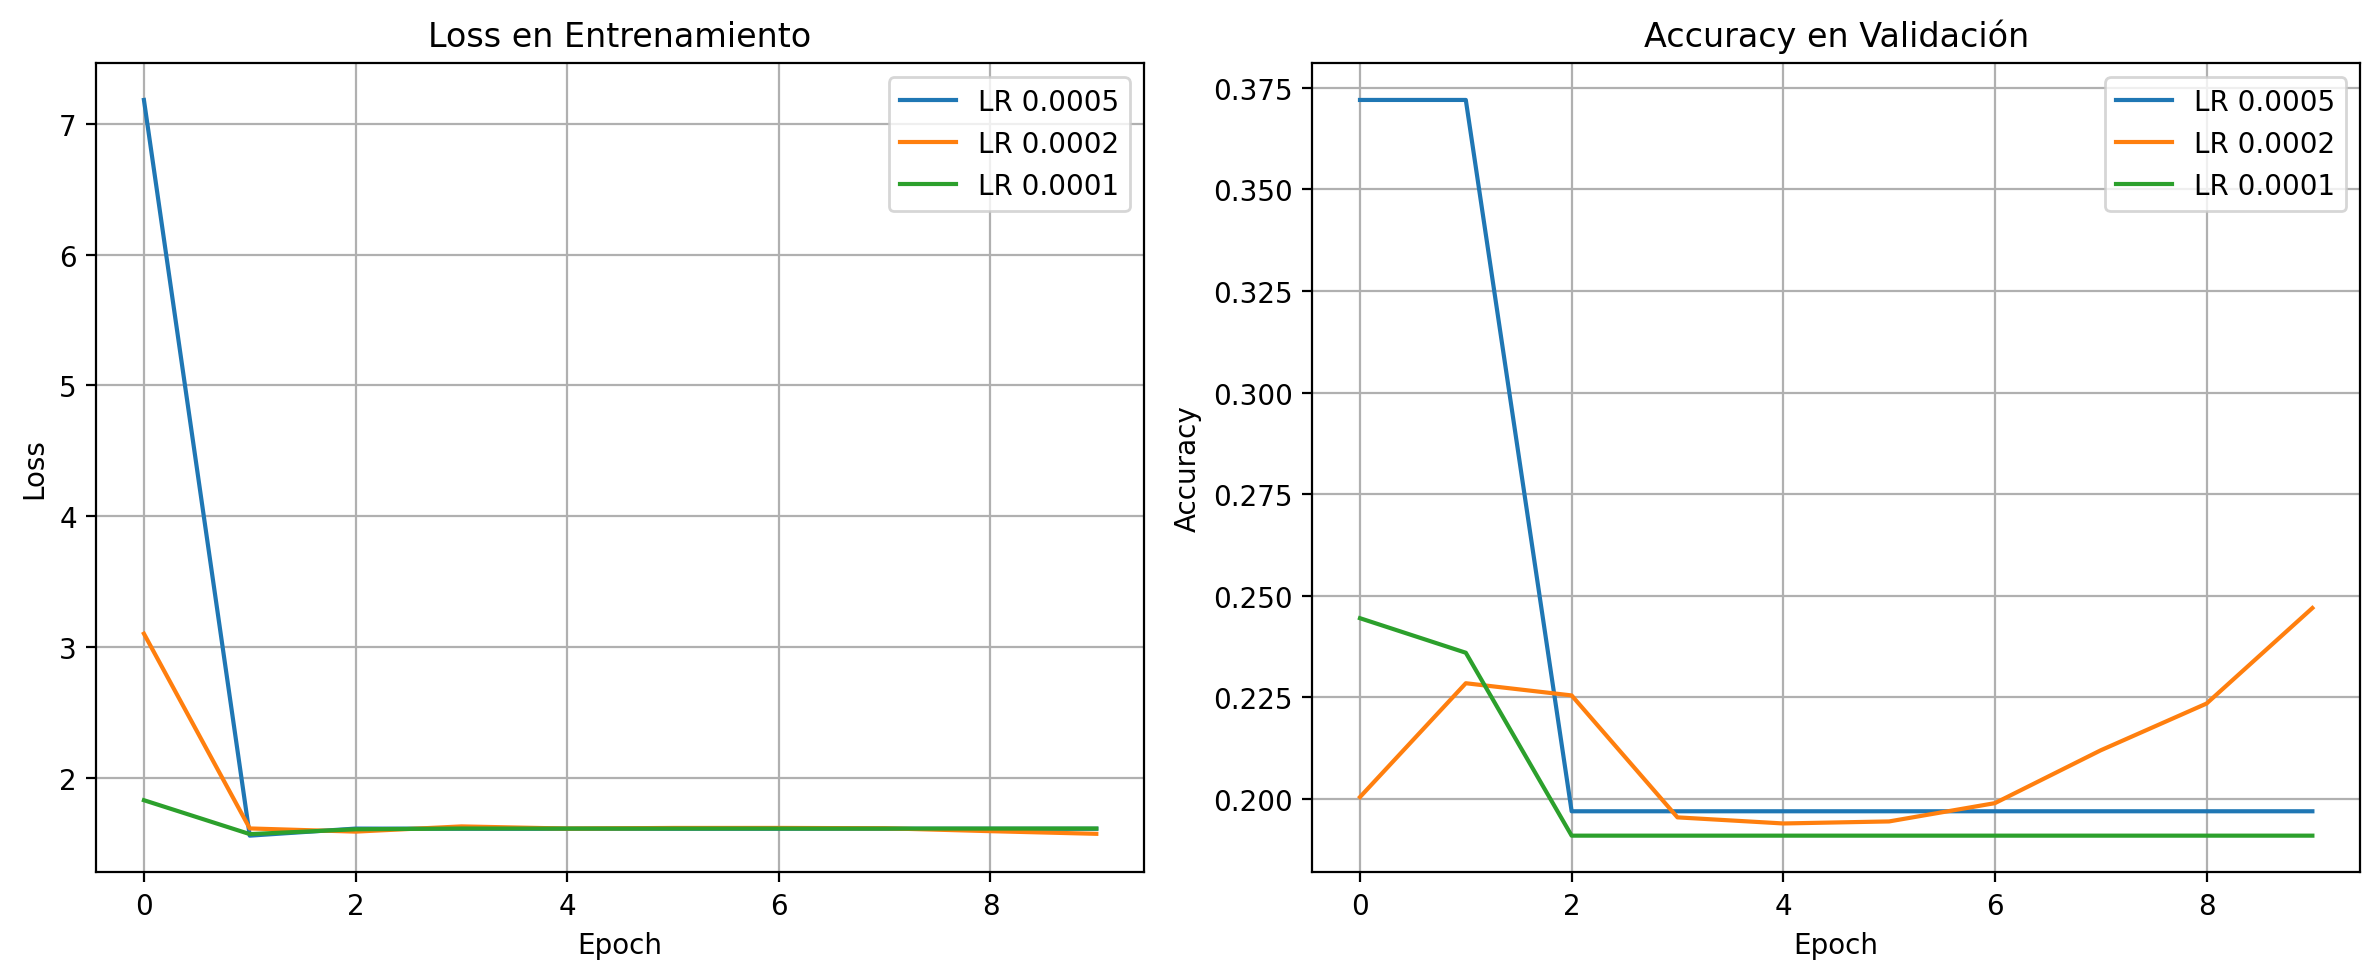

In [ ]:
import matplotlib.pyplot as plt

# Configurar la figura y los ejes
fig = plt.figure(dpi=200, figsize=(12, 5))

# Graficar la pérdida (loss) en el conjunto de entrenamiento
ax1 = plt.subplot(121)
for i in range(len(lrs)):
    ax1.plot(hists[i]['loss'], label=f'LR {lrs[i]}')
ax1.set_title('Loss en Entrenamiento')
ax1.legend()
ax1.grid(True)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')

# Graficar la precisión (accuracy) en el conjunto de validación
ax2 = plt.subplot(122)
for i in range(len(lrs)):
    ax2.plot(hists[i]['val_acc'], label=f'LR {lrs[i]}')
ax2.set_title('Accuracy en Validación')
ax2.legend()
ax2.grid(True)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')

# Mostrar las gráficas
plt.tight_layout()
plt.show()


Viendo las gráficas se puede v er que con unicamente el learning rate de 0.0002 se puede esperar mejoras en la precisión del modelo ya que no termina de estabilizarse la gráfica y sigue en subida, por tanto recordaremos esto para entrenar el modelo completo con el lr=0.0002

## Evaluacion de modelo

In [ ]:
import torch
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, Subset
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Define el modelo usando torch.nn.Sequential
model = torch.nn.Sequential(
    torch.nn.Linear(192 * 256 * 3, 50),  # Capa oculta con 50 neuronas
    torch.nn.ReLU(),
    torch.nn.Dropout(0.5),  # Dropout con una probabilidad de 0.5
    torch.nn.Linear(50, 5)  # Capa de salida con 5 neuronas (para 5 categorías)
)
# Mover el modelo al dispositivo
model.to(device)
# Cargar el estado del modelo guardado
model.load_state_dict(torch.load('ckpt.pt'))
model.eval()  # Establecer el modelo en modo de evaluación

# Evaluar el modelo en el DataLoader de validación
def evaluate_model(model, dataloader):
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_predictions)
    return accuracy

# Evaluar el modelo en el conjunto de prueba
test_accuracy = evaluate_model(model, val_loader)
print(f"Precisión en el conjunto de validación: {test_accuracy:.4f}")


/tmp/ipykernel_9015/3722968421.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('ckpt.pt'))


Precisión en el conjunto de validación: 0.2445


Se realiza la evaluación del subconjunto, es de esperarse que no sea un valor elevado debido a la poca cantidad de episodios realizados.

# Prueba con todos los datos

Finalmente, podemos probar con todos los datos del dataset. Aplicando el mismo modelo que usamos en las pruebas anteriores, estando seguros de escoger un buen learning rate, tambien estando seguros que nuestra GPU es capaz de manejar la carga del batch escogido y comprobado que no hay errores en el modelo.

In [ ]:
def fit(model, dataloader, optimizer, scheduler=None, epochs=10, log_each=1, weight_decay=0, early_stopping=0, verbose=1):
    criterion = torch.nn.CrossEntropyLoss()
    l, acc, lr = [], [], []
    val_l, val_acc = [], []
    best_acc, step = 0, 0

    # Mover el modelo al dispositivo
    model.to(device)

    # Imprimir dispositivo del modelo solo una vez
    print(f"Dispositivo del modelo: {next(model.parameters()).device}")

    for e in range(1, epochs + 1):
        _l, _acc = [], []
        for param_group in optimizer.param_groups:
            lr.append(param_group['lr'])

        model.train()
        for x_b, y_b in dataloader['train']:
            # Mover las etiquetas y los datos al dispositivo
            y_b = y_b.to(device)
            x_b = x_b.to(device)

            y_pred = model(x_b)
            loss = criterion(y_pred, y_b)
            _l.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            y_probas = torch.argmax(softmax(y_pred), axis=1)
            _acc.append(accuracy_score(y_b.cpu().numpy(), y_probas.cpu().detach().numpy()))

        l.append(np.mean(_l))
        acc.append(np.mean(_acc))

        model.eval()
        _l, _acc = [], []
        with torch.no_grad():
            for x_b, y_b in dataloader['val']:
                # Mover las etiquetas y los datos al dispositivo
                y_b = y_b.to(device)
                x_b = x_b.to(device)

                y_pred = model(x_b)
                loss = criterion(y_pred, y_b)
                _l.append(loss.item())
                y_probas = torch.argmax(softmax(y_pred), axis=1)
                _acc.append(accuracy_score(y_b.cpu().numpy(), y_probas.cpu().numpy()))

        val_l.append(np.mean(_l))
        val_acc.append(np.mean(_acc))

        # Guardar el mejor modelo
        if val_acc[-1] > best_acc:
            best_acc = val_acc[-1]
            torch.save(model.state_dict(), 'ckpt.pt')
            step = 0
            if verbose == 2:
                print(f"Mejor modelo guardado con acc {best_acc:.5f} en epoch {e}")

        step += 1
        if scheduler:
            scheduler.step(np.mean(_l))  # Pasar la pérdida de validación a scheduler.step()

        # Early stopping
        if early_stopping and step > early_stopping:
            print(f"Entrenamiento detenido en epoch {e} por no mejorar en {early_stopping} epochs seguidas")
            break

        if not e % log_each and verbose:
            print(f"Epoch {e}/{epochs} loss {l[-1]:.5f} acc {acc[-1]:.5f} val_loss {val_l[-1]:.5f} val_acc {val_acc[-1]:.5f} lr {lr[-1]:.5f}")

    # Cargar el mejor modelo
    model.load_state_dict(torch.load('ckpt.pt'))
    return {'epoch': list(range(1, len(l) + 1)), 'loss': l, 'acc': acc, 'val_loss': val_l, 'val_acc': val_acc, 'lr': lr}


Definimos el lr = 0.0002 en consecuencia del analisis de la grafica del entrenamiento de un subconjunto de datos. Y empezamos el entrenamiento

In [ ]:
# Configuración del entrenamiento con un solo valor de learning rate
lr = 0.0002  # La tasa de aprendizaje deseada
print(f"Entrenando con lr {lr}")

# Crear el modelo
model = build_model()

# Configurar el optimizador
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.01)  # Aplicar weight_decay para L2 Regularization

# Configurar el scheduler para reducir la tasa de aprendizaje basado en la pérdida de validación
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)

# Entrenar el modelo
hist = fit(model, {'train': train_loader, 'val': test_loader}, optimizer, scheduler=scheduler, epochs=1000, verbose=1, log_each=2)

# Puedes imprimir el historial de precisión y pérdida para verificar el rendimiento
print(f"Historial de entrenamiento con lr {lr}:")
print(f"Pérdida: {hist['loss']}")
print(f"Precisión: {hist['acc']}")
print(f"Pérdida de validación: {hist['val_loss']}")
print(f"Precisión de validación: {hist['val_acc']}")


Entrenando con lr 0.0002
Dispositivo del modelo: cuda:0


/home/antoniocf/Documents/ciencias de la computacion/6to Semestre/Inteligencia Artificial II/laboratorios/laboratorio2/lab2venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 2/1000 loss 1.53421 acc 0.26873 val_loss 1.48659 val_acc 0.35566 lr 0.00020
Epoch 4/1000 loss 1.50914 acc 0.28311 val_loss 1.42795 val_acc 0.38037 lr 0.00020
Epoch 6/1000 loss 1.44710 acc 0.28410 val_loss 1.32263 val_acc 0.36914 lr 0.00020
Epoch 8/1000 loss 1.40183 acc 0.28311 val_loss 1.22952 val_acc 0.38535 lr 0.00020
Epoch 10/1000 loss 1.37250 acc 0.37413 val_loss 1.22794 val_acc 0.54531 lr 0.00020
Epoch 12/1000 loss 1.34088 acc 0.38554 val_loss 1.15349 val_acc 0.57344 lr 0.00020
Epoch 14/1000 loss 1.34771 acc 0.38207 val_loss 1.17790 val_acc 0.56465 lr 0.00020
Epoch 16/1000 loss 1.30528 acc 0.38430 val_loss 1.04097 val_acc 0.56367 lr 0.00020
Epoch 18/1000 loss 1.24215 acc 0.38467 val_loss 0.98345 val_acc 0.60020 lr 0.00020
Epoch 20/1000 loss 1.22311 acc 0.39211 val_loss 1.05041 val_acc 0.62227 lr 0.00020
Epoch 22/1000 loss 1.22160 acc 0.38827 val_loss 0.96660 val_acc 0.59551 lr 0.00020
Epoch 24/1000 loss 1.20480 acc 0.41084 val_loss 0.87846 val_acc 0.65166 lr 0.00020
Epoch 26

KeyboardInterrupt: 

POdemos ver segun los resultado de los epochs, que el learning rate pareciera ser 0, pero realmente es demasiado pequeño que ya no abarcan los dígitos para su impresión en la consola, sin embargo, aplicamos una **interrupcion manual** a la ejecucion para simular que hubo un problema, o para aprovechar los pesos calculados hasta ahora y aplicarle otros parámetros.

## Nuevamente desde checkpoint

Entonces, seguiremos con el entrenamiento durante solamente 700 epochs, que es mas o menos lo que restaba antes de la interrupción del entrenamiento, además se cambió el learning rate a un valor fijo para ver el comportamiento con el modelo en lugar de reducirlo gradualmente segun pasan los epochs.

Cargamos el modelo desde el checkpoint ckpt.pt y volvemos a entrenar desde donde nos quedamos.

In [ ]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score

# Definir el dispositivo (GPU si disponible, sino CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def softmax(x):
    return torch.exp(x) / torch.exp(x).sum(axis=-1, keepdims=True)

def build_model():
    return torch.nn.Sequential(
        torch.nn.Linear(192 * 256 * 3, 50),  # Capa oculta con 50 neuronas
        torch.nn.ReLU(),
        torch.nn.Dropout(0.5),  # Dropout con una probabilidad de 0.5
        torch.nn.Linear(50, 5)  # Capa de salida con 5 neuronas (para 5 categorías)
    )

def fit(model, dataloader, optimizer, checkpoint_path='ckpt.pt', epochs=10, log_each=1, weight_decay=0, early_stopping=0, verbose=1):
    criterion = torch.nn.CrossEntropyLoss()
    l, acc, lr = [], [], []
    val_l, val_acc = [], []
    best_acc, step = 0, 0

    # Cargar el checkpoint si existe
    if checkpoint_path and os.path.exists(checkpoint_path):
        print(f"Cargando modelo desde {checkpoint_path}")
        model.load_state_dict(torch.load(checkpoint_path))
        print(f"Modelo cargado correctamente")

    # Mover el modelo al dispositivo
    model.to(device)

    # Imprimir dispositivo del modelo solo una vez
    print(f"Dispositivo del modelo: {next(model.parameters()).device}")

    for e in range(1, epochs + 1):
        _l, _acc = [], []
        for param_group in optimizer.param_groups:
            lr.append(param_group['lr'])

        model.train()
        for x_b, y_b in dataloader['train']:
            # Mover las etiquetas y los datos al dispositivo
            y_b = y_b.to(device)
            x_b = x_b.to(device)

            y_pred = model(x_b)
            loss = criterion(y_pred, y_b)
            _l.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            y_probas = torch.argmax(softmax(y_pred), axis=1)
            _acc.append(accuracy_score(y_b.cpu().numpy(), y_probas.cpu().detach().numpy()))

        l.append(np.mean(_l))
        acc.append(np.mean(_acc))

        model.eval()
        _l, _acc = [], []
        with torch.no_grad():
            for x_b, y_b in dataloader['val']:
                # Mover las etiquetas y los datos al dispositivo
                y_b = y_b.to(device)
                x_b = x_b.to(device)

                y_pred = model(x_b)
                loss = criterion(y_pred, y_b)
                _l.append(loss.item())
                y_probas = torch.argmax(softmax(y_pred), axis=1)
                _acc.append(accuracy_score(y_b.cpu().numpy(), y_probas.cpu().numpy()))

        val_l.append(np.mean(_l))
        val_acc.append(np.mean(_acc))

        # Guardar el mejor modelo
        if val_acc[-1] > best_acc:
            best_acc = val_acc[-1]
            torch.save(model.state_dict(), checkpoint_path)
            step = 0
            if verbose == 2:
                print(f"Mejor modelo guardado con acc {best_acc:.5f} en epoch {e}")

        step += 1

        # Early stopping
        if early_stopping and step > early_stopping:
            print(f"Entrenamiento detenido en epoch {e} por no mejorar en {early_stopping} epochs seguidas")
            break

        if not e % log_each and verbose:
            print(f"Epoch {e}/{epochs} loss {l[-1]:.5f} acc {acc[-1]:.5f} val_loss {val_l[-1]:.5f} val_acc {val_acc[-1]:.5f} lr {lr[-1]:.5f}")

    # Cargar el mejor modelo
    model.load_state_dict(torch.load(checkpoint_path))
    return {'epoch': list(range(1, len(l) + 1)), 'loss': l, 'acc': acc, 'val_loss': val_l, 'val_acc': val_acc, 'lr': lr}

# Configuración del entrenamiento con un learning rate fijo
learning_rate = 0.0001  # Learning rate fijo
model = build_model()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.01)  # Aplicar weight_decay para L2 Regularization

# Entrenar el modelo desde el checkpoint si existe
hist = fit(model, {'train': subset_train_loader, 'val': val_loader}, optimizer, checkpoint_path='ckpt.pt', epochs=700, verbose=1)


Cargando modelo desde ckpt.pt
Modelo cargado correctamente
Dispositivo del modelo: cuda:0


/tmp/ipykernel_9015/2250267987.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path))


Epoch 1/700 loss 1.24038 acc 0.42930 val_loss 0.91113 val_acc 0.65000 lr 0.00010
Epoch 2/700 loss 1.13067 acc 0.45937 val_loss 0.88150 val_acc 0.71750 lr 0.00010
Epoch 3/700 loss 1.06272 acc 0.50352 val_loss 0.78858 val_acc 0.72100 lr 0.00010
Epoch 4/700 loss 0.98244 acc 0.55937 val_loss 0.73815 val_acc 0.74000 lr 0.00010
Epoch 5/700 loss 1.05164 acc 0.51797 val_loss 0.78630 val_acc 0.74450 lr 0.00010
Epoch 6/700 loss 1.09823 acc 0.48281 val_loss 0.81952 val_acc 0.74050 lr 0.00010
Epoch 7/700 loss 1.08325 acc 0.49688 val_loss 0.99358 val_acc 0.65750 lr 0.00010
Epoch 8/700 loss 1.04511 acc 0.51133 val_loss 0.83724 val_acc 0.73400 lr 0.00010
Epoch 9/700 loss 1.06539 acc 0.51562 val_loss 0.81333 val_acc 0.75200 lr 0.00010
Epoch 10/700 loss 1.03384 acc 0.48047 val_loss 0.82368 val_acc 0.72650 lr 0.00010
Epoch 11/700 loss 1.04085 acc 0.50039 val_loss 0.83221 val_acc 0.70800 lr 0.00010
Epoch 12/700 loss 0.98958 acc 0.54805 val_loss 0.90146 val_acc 0.68250 lr 0.00010
Epoch 13/700 loss 1.02896

/tmp/ipykernel_9015/2250267987.py:96: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path))


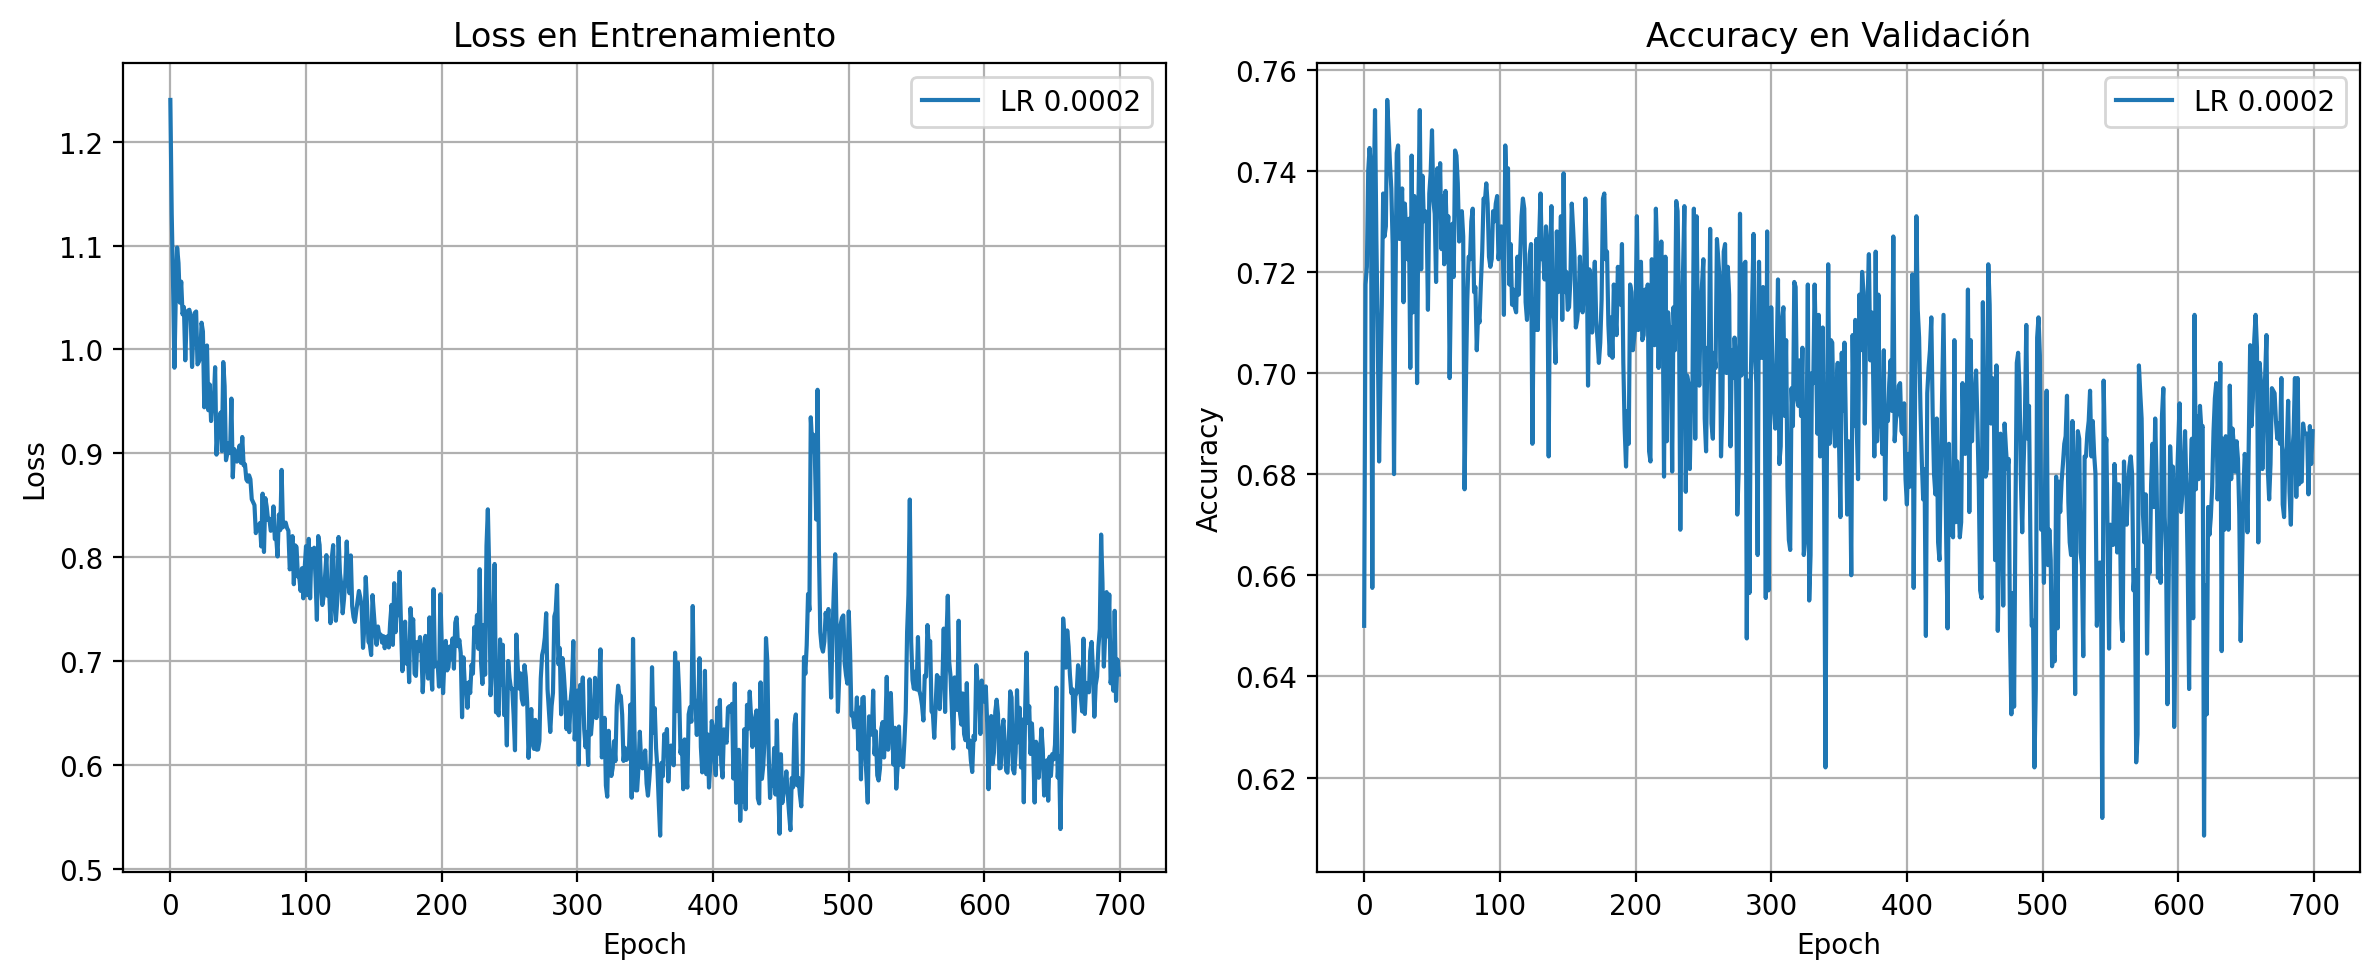

In [ ]:
import matplotlib.pyplot as plt

# Configurar la figura y los ejes
fig = plt.figure(dpi=200, figsize=(12, 5))

# Graficar la pérdida (loss) en el conjunto de entrenamiento
ax1 = plt.subplot(121)
ax1.plot(hist['loss'], label=f'LR {lr}')  # Usa el valor actual de lr
ax1.set_title('Loss en Entrenamiento')
ax1.legend()
ax1.grid(True)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')

# Graficar la precisión (accuracy) en el conjunto de validación
ax2 = plt.subplot(122)
ax2.plot(hist['val_acc'], label=f'LR {lr}')  # Usa el valor actual de lr
ax2.set_title('Accuracy en Validación')
ax2.legend()
ax2.grid(True)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')

# Mostrar las gráficas
plt.tight_layout()
plt.show()


## Evaluacion de modelo

Una vez terminado, debemos hacer una evaluación de la precisión del modelo y realizar algunas predicciones visuales para ver más facil su respuesta.

In [ ]:
import torch
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader
import numpy as np

# Configurar el dispositivo (GPU si está disponible, sino CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Definir el modelo usando torch.nn.Sequential
model = torch.nn.Sequential(
        torch.nn.Linear(192 * 256 * 3, 50),  # Capa oculta con 50 neuronas
        torch.nn.ReLU(),
        torch.nn.Dropout(0.5),  # Dropout con una probabilidad de 0.5
        torch.nn.Linear(50, 5)  # Capa de salida con 5 neuronas (para 5 categorías)

)


# Mover el modelo al dispositivo
model.to(device)

# Cargar el estado del modelo guardado
model.load_state_dict(torch.load('ckpt.pt'))
model.eval()  # Establecer el modelo en modo de evaluación

# Crear DataLoader para prueba
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

def evaluate_model(model, dataloader):
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in dataloader:
            # Mover los datos al dispositivo
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_predictions)
    return accuracy

# Evaluar el modelo en el conjunto de prueba
test_accuracy = evaluate_model(model, test_loader)
print(f"Precisión en el conjunto de prueba: {test_accuracy:.4f}")


/tmp/ipykernel_9015/778566829.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('ckpt.pt'))


Precisión en el conjunto de prueba: 0.7300


Obtuvimos una precisión del 73%

/tmp/ipykernel_11736/3222785948.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('ckpt.pt'))


Precisión en el conjunto de prueba: 0.7465


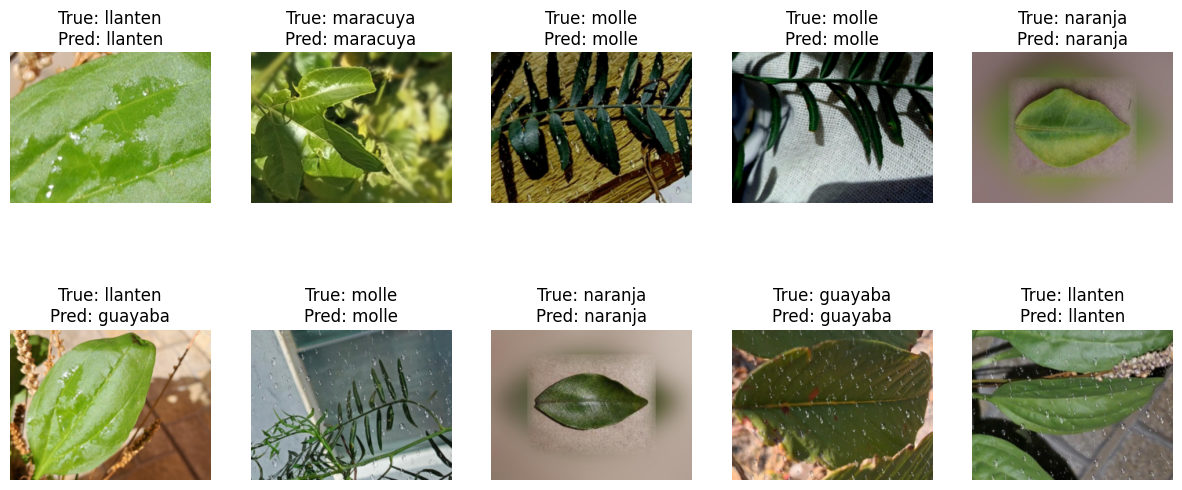

In [ ]:
import torch
from torchvision import transforms
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np  # Asegúrate de importar numpy

# Configurar el dispositivo (GPU si está disponible, sino CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Definir el modelo usando torch.nn.Sequential
model = torch.nn.Sequential(
        torch.nn.Linear(192 * 256 * 3, 50),  # Capa oculta con 50 neuronas
        torch.nn.ReLU(),
        torch.nn.Dropout(0.5),  # Dropout con una probabilidad de 0.5
        torch.nn.Linear(50, 5)  # Capa de salida con 5 neuronas (para 5 categorías)
)

# Mover el modelo al dispositivo
model.to(device)

# Cargar el estado del modelo guardado
model.load_state_dict(torch.load('ckpt.pt'))
model.eval()  # Establecer el modelo en modo de evaluación

# Crear DataLoader para prueba
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

def evaluate_model(model, dataloader):
    all_labels = []
    all_predictions = []
    all_images = []  # Para almacenar imágenes para la visualización

    with torch.no_grad():
        for images, labels in dataloader:
            # Mover los datos al dispositivo
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            all_images.extend(images.cpu())

    # Seleccionar 10 índices aleatorios
    num_samples = 10
    indices = np.random.choice(len(all_images), num_samples, replace=False)
    random_images = [all_images[i] for i in indices]
    random_labels = [all_labels[i] for i in indices]
    random_predictions = [all_predictions[i] for i in indices]

    accuracy = accuracy_score(all_labels, all_predictions)
    return accuracy, random_images, random_labels, random_predictions

# Evaluar el modelo en el conjunto de prueba
test_accuracy, sample_images, sample_labels, sample_predictions = evaluate_model(model, test_loader)
print(f"Precisión en el conjunto de prueba: {test_accuracy:.4f}")

# Función para desaplanar y visualizar imágenes con nombre de la clase y predicción
def unflatten_and_show(images, labels, predictions, classes, original_size=(192, 256)):
    # Convertir el tensor de imágenes a su forma original
    num_images = len(images)
    images_unflattened = [img.view(3, original_size[0], original_size[1]) for img in images]

    # Visualizar las imágenes
    r, c = 2, 5  # 2 filas, 5 columnas
    plt.figure(figsize=(c*3, r*3))

    for i in range(num_images):
        plt.subplot(r, c, i + 1)
        img = images_unflattened[i]
        label = labels[i]
        pred = predictions[i]
        plt.imshow(img.permute(1, 2, 0))  # Cambiar la forma para la visualización (canales a la última dimensión)
        plt.axis('off')
        plt.title(f"True: {classes[label]}\nPred: {classes[pred]}")  # Mostrar la clase verdadera y la predicción

    plt.subplots_adjust(wspace=0.2, hspace=0.5)
    plt.show()

# Mostrar imágenes con sus predicciones
unflatten_and_show(sample_images, sample_labels, sample_predictions, dataset.classes)


En las imagenes superiores se puede ver visualmente unas predicciones realizadas de forma gráfica, comparando en True el valor esperado y en Pred el valor obtenido.

# Exportacion en Onnx

Finalmente exportamos nuestro modelo en Onnx y en torchscript para que nuestro modelo quede grabado y pueda ser utilizado en distintos entornos.

In [ ]:
!pip install onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 82.3 MB/s eta 0:00:00


In [ ]:
state_dict = torch.load('ckpt.pt')
print(state_dict.keys())

odict_keys(['0.weight', '0.bias', '3.weight', '3.bias'])


/tmp/ipykernel_11736/1753738586.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('ckpt.pt')


In [ ]:
import torch
import torch.onnx

# Define el modelo usando torch.nn.Sequential
model = torch.nn.Sequential(
        torch.nn.Linear(192 * 256 * 3, 50),  # Capa oculta con 50 neuronas
        torch.nn.ReLU(),
        torch.nn.Dropout(0.5),  # Dropout con una probabilidad de 0.5
        torch.nn.Linear(50, 5)  # Capa de salida con 5 neuronas (para 5 categorías)
)

# Cargar el estado del modelo guardado
model.load_state_dict(torch.load('ckpt.pt'))
model.eval()  # Establecer el modelo en modo de evaluación

# Definir un tensor de entrada ficticio
dummy_input = torch.randn(1, 192 * 256 * 3)  # Ajustar las dimensiones según tu modelo

# Exportar el modelo a ONNX
torch.onnx.export(
    model,  # El modelo que deseas exportar
    dummy_input,  # Un tensor de entrada ficticio para el modelo
    'model.onnx',  # Nombre del archivo de salida
    input_names=['input'],  # Nombre del tensor de entrada (opcional)
    output_names=['output'],  # Nombre del tensor de salida (opcional)
    export_params=True,  # Exportar los parámetros del modelo
    verbose=False,  # Detalles del proceso de exportación
    opset_version=11  # Versión del conjunto de operaciones ONNX (ajusta según sea necesario)
)


/tmp/ipykernel_11736/2523981831.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('ckpt.pt'))


# Exportacion en Torchscript

In [ ]:
import torch

# Define el modelo usando torch.nn.Sequential
model = torch.nn.Sequential(
        torch.nn.Linear(192 * 256 * 3, 50),  # Capa oculta con 50 neuronas
        torch.nn.ReLU(),
        torch.nn.Dropout(0.5),  # Dropout con una probabilidad de 0.5
        torch.nn.Linear(50, 5)  # Capa de salida con 5 neuronas (para 5 categorías)
)

# Cargar el estado del modelo guardado
model.load_state_dict(torch.load('ckpt.pt'))
model.eval()  # Establecer el modelo en modo de evaluación

# Definir un tensor de entrada ficticio
dummy_input = torch.randn(1, 192 * 256 * 3)  # Ajustar las dimensiones según tu modelo

# Convertir el modelo a TorchScript usando tracing
scripted_model = torch.jit.trace(model, dummy_input)

scripted_model.save('model_traced.pt')



/tmp/ipykernel_11736/2137089397.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('ckpt.pt'))
